# **Project 1: Lyft Bay Wheels Recommendations**

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## **0.Prefix and Summary**

This project aims to answer two questions:
1. What are the 5 most popular trips that I would call "commuter trips"? 
2. What are my recommendations for offers (justified based on my findings)?

My responses to the aboves are as follows:
1. The five most popular commuter trips are 
   1. San Francisco Caltrain 2 (330 Townsend) to Townsend at 7th
   2. Harry Bridges Plaza (Ferry Building) to 2nd at Townsend
   3. 2nd at Townsend to Harry Bridges Plaza (Ferry Building)
   4. Embarcadero at Sansome to Steuart at Market
   5. San Francisco Caltrain (Townsend at 4th) to Harry Bridges Plaza (Ferry Building)

I define commuter trips to be trips that begin anywhere from 6-9am or 4-7pm since these are the hours most people commute to and from work. My dataset does not include trips that have durations above the 99th percentile for trip durations which is 3.2 hours (see appendix for more details).

2. Because most bike trips are made by subscribers and most subscribers appear to be commuters that ride bikes for less than 30 minutes, I suggest either increasing the amount of the monthly or yearly membership fee or decreasing the amount of time per trip that is included as a part of the membership with no additional fee. I also suggest increasing marketing and awareness for the corporate memberships deal since most of the subsribers appear to be commuters to and from and work.

## **1. Data for 5 Most Popular Commuter Trips**

In [2]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT start_station_name, end_station_name, count(*) as number_of_trips FROM `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time`  WHERE start_station_name <> end_station_name AND (start_hour = 6 OR start_hour = 7 OR start_hour= 8 OR start_hour = 9 OR start_hour = 16 OR start_hour = 17 OR start_hour = 18 OR start_hour = 19) GROUP BY start_station_name, end_station_name ORDER BY number_of_trips DESC LIMIT 5' > trips.csv

Waiting on bqjob_r186b6c32bc6aa075_00000174dd91836c_1 ... (0s) Current status: DONE   


In [3]:
com_trips = pd.read_csv('trips.csv')

In [4]:
com_trips

,start_station_name,end_station_name,number_of_trips
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5912
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5744
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5511
3,Embarcadero at Sansome,Steuart at Market,5357
4,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),5249


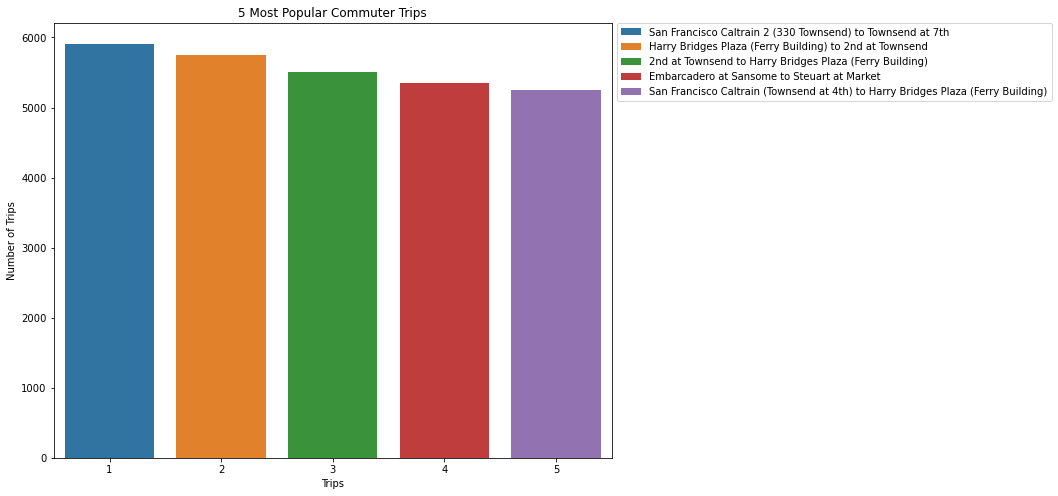

In [5]:
trips  = []
for i in np.arange(5):
     trips.append(com_trips["start_station_name"][i] + str(" to ") + com_trips["end_station_name"][i])
com_trips["trips"] = trips
plt.figure(figsize=(10,8))
sns.barplot(x = list(np.arange(1,6)), y = "number_of_trips", hue = "trips", data = com_trips, dodge=False)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("5 Most Popular Commuter Trips")
plt.xlabel("Trips")
plt.ylabel("Number of Trips")
plt.show()

#### **Notes on Defining Commuter Trips:**
As mentioned above, I define commuter trips as trips that begin anywhere from 6-9am or 4-7pm since these are the hours most people commute to and from work. My dataset does not include trips that have durations above the 99th percentile for trip durations which is 3.2 hours (see appendix for more details).

 ## **2. Data For Recommendations**

### **2.1 Percent of Subscribers vs Customers**

In [6]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type, COUNT(*) as num_trips FROM `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time` GROUP BY subscriber_type  ORDER BY num_trips DESC' > sub_types.csv

Waiting on bqjob_r57fd402f49260f7d_00000174dd91917d_1 ... (0s) Current status: DONE   


In [7]:
sub_types = pd.read_csv('sub_types.csv')

In [8]:
sub_types

,subscriber_type,num_trips
0,Subscriber,845915
1,Customer,128143


[0.8684441788887315, 0.13155582111126854]


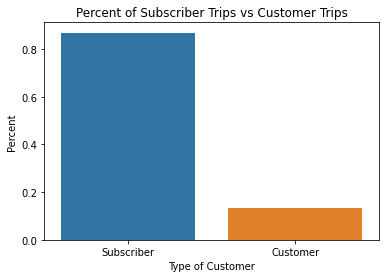

In [9]:
total_trips = sum(sub_types["num_trips"])
percents = []
for i in range(2):
    percents.append(sub_types["num_trips"][i]/total_trips)
sub_types["percents"] = percents
print(percents)

sns.barplot(x = "subscriber_type", y = "percents", data = sub_types, dodge=False)
plt.title("Percent of Subscriber Trips vs Customer Trips")
plt.xlabel("Type of Customer")
plt.ylabel("Percent")
plt.show()

#### **Takeaway from this Graph:**

From this graph, we learn that about 87% of trips are made by subscribers whereas only about 13% are made by customers.

### **2.2 Distributions of Trip Duration Minutes for Subscribers vs Customers**

In [10]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type, duration_minutes FROM `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time`' > sub_times.csv

Waiting on bqjob_r5f695a6c0f1437ae_00000174dd9199a9_1 ... (0s) Current status: DONE   


In [11]:
sub_times = pd.read_csv('sub_times.csv')

In [12]:
sub_times.head()

,subscriber_type,duration_minutes
0,Subscriber,3
1,Subscriber,18
2,Subscriber,19
3,Subscriber,19
4,Subscriber,19


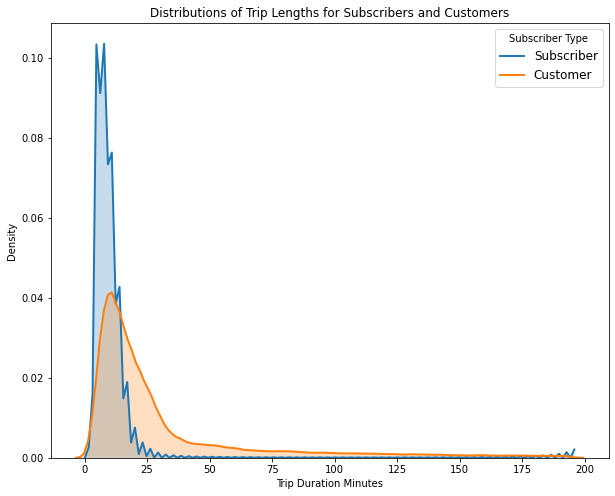

In [13]:
plt.figure(figsize=(10,8))
sns.distplot(sub_times.loc[sub_times['subscriber_type'] == 'Subscriber', 'duration_minutes'],hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 2}, label = "Subscriber")
sns.distplot(sub_times.loc[sub_times['subscriber_type'] == 'Customer', 'duration_minutes'],hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 2}, label = "Customer")
plt.legend(prop={'size': 12}, title = 'Subscriber Type')
plt.xlabel("Trip Duration Minutes")
plt.ylabel("Density")
plt.title("Distributions of Trip Lengths for Subscribers and Customers")
plt.show()

#### **Takeaway from this Graph:**

From this graph, we can see that the distribution for subscriber trip durations is much more narrow than the distribution for customer trip durations. Almost all of the trips made by subscribers are under 25 minutes. Many of the trips made by customers are also under 25 minutes; however unlike the distribution for the subscriber trip durations, the distribution for the customer trip durations has a long tail. This means that a greater fraction of customers than subscribers take trips that are much longer than 25 minutes. A greater percent of customers are riding longer than subscribers. 

### **2.3 Days Customers vs Subscribers Use Bikes**

In [14]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type, dow_weekday AS week_day, COUNT(trip_id) as num_trips FROM `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time` GROUP BY subscriber_type, week_day ORDER BY num_trips DESC' > sub_days.csv

Waiting on bqjob_r5b40b0b6d0768afb_00000174dd920045_1 ... (0s) Current status: DONE   


In [15]:
sub_days = pd.read_csv('sub_days.csv')

In [16]:
sub_days.head()

,subscriber_type,week_day,num_trips
0,Subscriber,Weekday,789506
1,Customer,Weekday,77001
2,Subscriber,Weekend,56409
3,Customer,Weekend,51142


[0.9333159951058912, 0.6008989956532936, 0.06668400489410875, 0.3991010043467064]


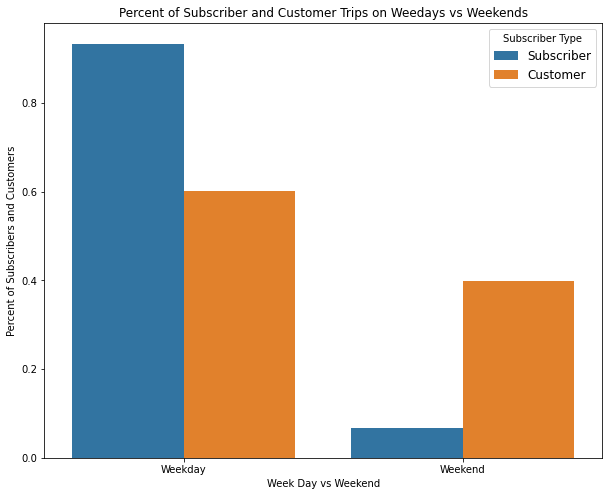

In [17]:
total_sub_days = sum(sub_days.loc[sub_days["subscriber_type"] == "Subscriber"]["num_trips"])
total_cust_days = sum(sub_days.loc[sub_days["subscriber_type"] == "Customer"]["num_trips"])

percents = []
i = 0
while i < 4:
    percents.append(sub_days.loc[sub_days["subscriber_type"] == "Subscriber"]["num_trips"][i]/total_sub_days)
    i+=1
    percents.append(sub_days.loc[sub_days["subscriber_type"] == "Customer"]["num_trips"][i]/total_cust_days)
    i+=1
print(percents)
sub_days["percents"] = percents 

plt.figure(figsize=(10,8))
sns.barplot(x="week_day",y="percents",hue = "subscriber_type", data = sub_days)
plt.legend(prop={'size': 12}, title = 'Subscriber Type')
plt.title("Percent of Subscriber and Customer Trips on Weedays vs Weekends")
plt.xlabel("Week Day vs Weekend")
plt.ylabel("Percent of Subscribers and Customers")
plt.show()


#### **Takeaway from this Chart:**

From this chart, we can see that about 93% of subscriber trips happen on weekdays whereas about 7% happens on the weekends. On the other hand, only about 40% of customer trips happend on weekdays whereas 60% happen on weekends. Thus, subscribers are more likely to commute during the week than customers.

### **2.4 Trip Start Hours: Subscribers vs Customers**

In [18]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type, start_hour, count(*) as num_trips FROM `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time` GROUP BY subscriber_type,start_hour ORDER BY num_trips DESC, subscriber_type' > sub_hours.csv

Waiting on bqjob_r462ee7a25db4d7a7_00000174dd920868_1 ... (0s) Current status: DONE   


In [19]:
sub_hours = pd.read_csv('sub_hours.csv')

In [20]:
sub_hours.head()

,subscriber_type,start_hour,num_trips
0,Subscriber,8,127036
1,Subscriber,17,114840
2,Subscriber,9,89427
3,Subscriber,16,75995
4,Subscriber,18,75711


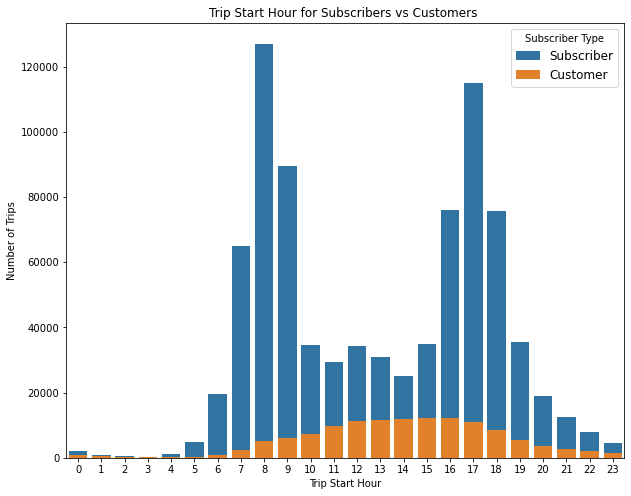

In [21]:
plt.figure(figsize=(10,8))
sns.barplot(x = "start_hour", y = "num_trips", hue = "subscriber_type",data = sub_hours,dodge = False)
plt.legend(prop={'size': 12}, title = 'Subscriber Type')
plt.xlabel("Trip Start Hour")
plt.ylabel("Number of Trips")
plt.title("Trip Start Hour for Subscribers vs Customers ")
plt.show()

#### **Takeway From this Chart:**

This chart shows that most subscribers begin their trips at 7am,8am,and 9am and 4pm, 5pm, and 6pm. These are commuting hours which means subscribers are probably commuting to and from work on the bikes. On the other hand, the most common start hours for customers are 12pm, 1pm, 2pm, 3pm, and 4pm. These are not commuting hours. Putting this together with the previous graph which shows that a larger percent of customers ride bikes on the weekends than the weekdays, it appears that customers are riding the bikes perhaps for leisure rather than commuting to and from work. 

### **2.5 Starting Hours for All Trips**

In [22]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT COUNT(trip_id) as num_trips, start_hour FROM `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time` GROUP BY start_hour ORDER BY num_trips DESC' > pop_hours.csv

Waiting on bqjob_r64c56aedd68cde8a_00000174dd9211ad_1 ... (0s) Current status: DONE   


In [23]:
pop_hours = pd.read_csv('pop_hours.csv')

In [24]:
pop_hours.head(5)

,num_trips,start_hour
0,132060,8
1,125933,17
2,95420,9
3,88273,16
4,84311,18


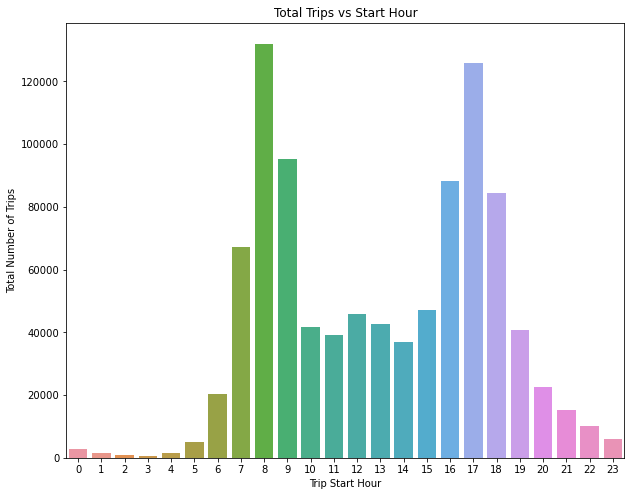

In [25]:
plt.figure(figsize=(10,8))
sns.barplot(x = "start_hour", y = "num_trips", data = pop_hours, dodge=False)
plt.title("Total Trips vs Start Hour")
plt.xlabel("Trip Start Hour")
plt.ylabel("Total Number of Trips")
plt.show()

#### **Takeway from this Chart:**

From this graph, we can see that the most trips occur at 7,8,and 9am and 4,5, and 6 p.m. Thus, it would appear that most of the trips are occuring at commuter hours. These are the hours that people are most likely to commute to and from work so it is probable that many of the bike trips are made by commuters to and from work.

### **2.6 Duration Minutes for 5 Most Popular Trips**

In [26]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT start_station_name, end_station_name, AVG(duration_minutes) as mean_mins,count(*) AS number_of_trips FROM `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time` WHERE start_station_name <> end_station_name GROUP BY start_station_name, end_station_name ORDER BY number_of_trips DESC LIMIT 5' > pop_trips.csv

Waiting on bqjob_r128d4a86ba8abe90_00000174dd921a4c_1 ... (0s) Current status: DONE   


In [27]:
pop_trips = pd.read_csv('pop_trips.csv')

In [28]:
pop_trips

,start_station_name,end_station_name,mean_mins,number_of_trips
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,16.501051,9043
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4.368204,8498
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),9.141261,7610
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,10.369170,6883
4,Embarcadero at Sansome,Steuart at Market,7.679889,6857


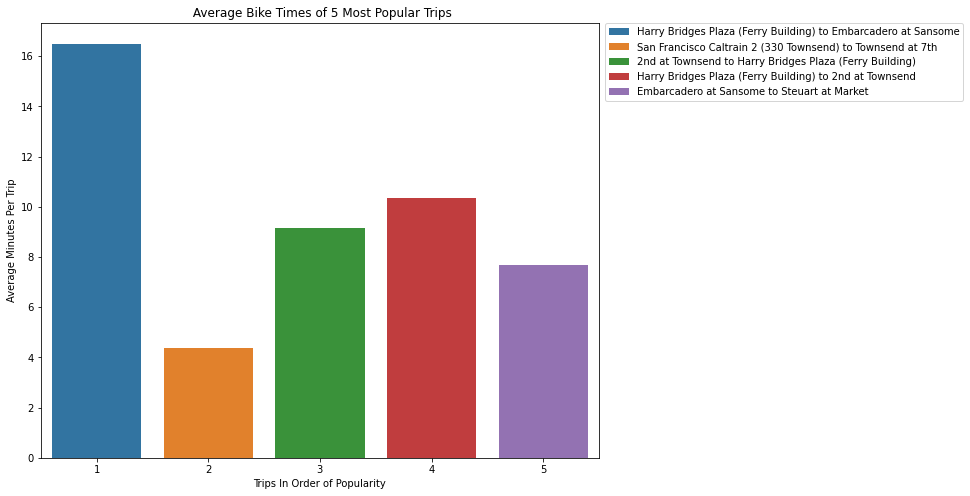

In [29]:
trips  = []
for i in np.arange(5):
     trips.append(pop_trips["start_station_name"][i] + str(" to ") + pop_trips["end_station_name"][i])
pop_trips["trips"] = trips
plt.figure(figsize=(10,8))
sns.barplot(x = list(np.arange(1,6)), y = "mean_mins", hue = "trips", data = pop_trips, dodge=False)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title(" Average Bike Times of 5 Most Popular Trips")
plt.xlabel("Trips In Order of Popularity")
plt.ylabel("Average Minutes Per Trip")
plt.show()

#### **Takeaway from this Chart:**

As one can see from the graph above, the 5 most popular trips in terms of number of bike rides are on average less than 30 mins. The closest bike trip that comes close to 30 mins is the most popular trip which is from the Ferry Building to Embarcadero at Sansome which is on average 16 mins. Lyft Bay Wheels' currently offers a monthly membership for 15 dollars per month which offers members unlimited 45 minute rides. If the ride is longer than 30 minutes, members pay an additional 3 dollars per hour. On the other hand, non-members must pay for single rides. Each single ride is 2 dollars for the first 30 minutes and then an additional 3 dollars for every 15 minutes after. Considering most of the trips are made by members, it would make sense to raise the price. 

### **2.7 Average Duration for All Trips** 
Average time of a trip, disregarding trips above the 99th percentile of 3.2 hours: **12 minutes**

SQL Query:
```sql
   SELECT AVG(duration_minutes) 
   FROM `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time` 
   ```

## **3. Recommendations Based on Data and Takeaways**

I found that a majority of the riders are subscribers instead of commuters. A larger percentage of subscribers ride bikes at commuting hours such as 7 - 9am and 4pm-6pm (2.4) and almost all subscriber trips, about 93% are made on weekdays instead of weekends(2.3). Due to these facts, the data shows that most of the subscribers use the bikes to commute to and from work. Because about 87% of trips are made by subscribers (2.1), I believe subscribers and thus commuters are the main users of Lyft bikes. They are the main target demographic. On the other hand, a larger percentage of customer trips are made at 12,1,2,and 3pm(2.4) and about 60% of trips occur on weekends (2.3). Due to this, the data shows that most of the customers, unlike the subscribers, do not ride the bikes for commuting purposes. 
   
Furthermore, I learned that the average trip is about 12 minutes(2.7). The average bikes times of the 5 most popular trips, subscriber or customer, are all under 30 minutes. Almost all of the trips made by subscribers are under 25 minutes. Many of the trips made by customers are also under 25 minutes; however unlike the distribution for the subscriber trip durations, the distribution for the customer trip durations has a long tail. This means that a greater fraction of customers than subscribers take trips that are much longer than 25 minutes. A greater percent of customers are riding longer than subscribers. 
    
Because most customers are subscribers and most subscribers appear to be commuters that ride bikes for less than 30 minutes, I would suggest either increasing the amount of the monthly or yearly membership or decreasing the amount of time per trip that is included as a part of the membership with no additional fee. Members currently receive unlimited 45 minute bike rides and must pay an additional 3 dollars per 15 minutes; however, most members ride under 30 minutes meaning Lyft Bay Wheels is not receiving the additional 3 dollars per 15 minutes very frequently from subscribers. Decreasing the amount of time per trip that is included as a part of the additional membership to perhaps 20 minutes would increase revenue for the company. Increasing the membership fee and leaving the 45 free minutes as is could also increase revenue. Because riding a bike to work is a much cheaper alternative of commuting to work than BART, UBER, or driving, the company could test how much more revenue they could receive by increasing the price of membership or decreasing the amount of free minutes included per trip as part of membership. The demand for traveling to work should be relatively inelastic if the price of membership remains less than the prices of the other means of transportation. However, because most of the bike trips are under 30 minutes, it may be possible for a large segment of the commuters to walk to work instead of riding their bikes. Comparing the opportunity cost of time saved from walking to work to the cost of membership could help the company determine the optimal price.
   
Another recommendation is to increase marketing for the corporate memberships deal. Lyft Bay Wheels' corporate membership deal allows companies to purchase subsidized plans for their employees. Because one of Lyft Bay Wheels' largest target demographic is commuters to and from work, the company could increase the number of bike trips by partnering with more companies to capture the commuter demographic. 

## **4. Appendix**

### **4.1 Information About Views Used**

#### **4.1.1 List of Views Used For My Analysis in Notebook:**
1. `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time` 
2. `september-2020-288223.bike_trip_data.Duration_Table`

#### **4.1.2 Explanation about Views:**
1. The Duration_and_Cleaned_Time table is built from the Duration_Table. The Duration_and_Cleaned_Time_Table includes all of the data from the Duration_Table but it adds the day of week, time of day, and start hour of each trip. It also filters the Duration_Table to only include bike trips that lasted under 3.2 hours which represents the 99th percentile of the duration of all bike trips.

```
Query for 99th percentile of 3.2 hours:
```

```sql
SELECT APPROX_QUANTILES(duration_minutes, 100)[OFFSET(99)] AS percentile_99,
FROM `september-2020-288223.bike_trip_data.Duration_Table`
```
```
192/60 = 3.16 = 3.2 hours
```


2. The Duration_Table is built from the `bigquery-public-data.san_francisco.bikeshare_trips` table. It includes select columns from the bike_share_trips table and adds the duration minutes, duration hours rounded, and duration hours rounded to the tenths place for each trip.

### **4.2 Queries to Get Views**

#### **4.2.1 Query for `september-2020-288223.bike_trip_data.Duration_and_Cleaned_Time`**
```sql
select *,   
       EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
       CASE EXTRACT(DAYOFWEEK FROM start_date)
           WHEN 1 THEN "Sunday"
           WHEN 2 THEN "Monday"
           WHEN 3 THEN "Tuesday"
           WHEN 4 THEN "Wednesday"
           WHEN 5 THEN "Thursday"
           WHEN 6 THEN "Friday"
           WHEN 7 THEN "Saturday"
           END AS dow_str,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
           ELSE "Weekday"
           END AS dow_weekday,
       EXTRACT(HOUR FROM start_date) AS start_hour,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN "Nightime"
           WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN "Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN "Mid Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN "Mid Day"
           WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN "Early Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN "Evening"
           END AS start_hour_str
FROM `september-2020-288223.bike_trip_data.Duration_Table`
WHERE duration_hours_tenths <= 3.2
```

#### **4.2.2 Query for `september-2020-288223.bike_trip_data.Duration_Table`**
```sql
select trip_id,start_date, duration_sec,start_station_name,start_station_id, end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,
       CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes,
       CAST(ROUND(duration_sec / 3600.0) AS INT64) AS duration_hours_rounded,
       ROUND(duration_sec / 3600.0, 1) AS duration_hours_tenths
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
ORDER BY start_date ASC
```